# Model with TCGNA data

The purpose of this notebook is to prototype an ML model using pytorch and wandb. I'll based it on TCGNA, specifically from the following [paper](https://www.cell.com/cancer-cell/fulltext/S1535-6108(17)30053-3).

Disclaimer: I'm not a cancer expert and I'm doing this without guidance from one.

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
pd.set_option("display.max_columns", None)
rng = np.random.default_rng(12345)
sns.set_context("notebook")
sns.set_palette("colorblind")

In [4]:
DATA_DIR = "/Users/benlacar/Documents/career/data_science/repos/wandb-explore/data/"

# Explore clinical data

In [5]:
df_clinical = pd.read_excel(
    Path(DATA_DIR, "Cherniack_s1_clinical_data.xlsx"), skiprows=1
)
print(df_clinical.shape)
df_clinical.head()

(57, 53)


/Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,clinical_stage,primary_therapy_outcome_success,new_tumor_event_after_initial_treatment,days_to_new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,vital_status,DiseaseStatus,InferredTumorStatus,Prog/Recurrence,PFS,OS,days_to_death,days_to_last_followup,form_completion_date,height,weight,race,ethnicity,prior_malignancy,radiation_therapy,postoperative_rx_tx,histological_type,year_of_initial_pathologic_diagnosis,surgical_approach,peritoneal_wash,pct_tumor_invasion,total_pelv_lnr,pln_pos_light_micro,pln_pos_ihc,total_pelv_lnp,total_aor_lnr,aln_pos_light_micro,aln_pos_ihc,total_aor-lnp,patient_id,residual_tumor,system_version,tissue_source_site,Frozen % Sarc.,Frozen % Carc.,Frozen Poorly Diff %,Serous %,Endometroid %,Poorly DifferentiatedEpith %,Squamous %,UndifferentiatedSarc %,Leiomyosarcoma %,Heterologous cartilage %,Heterologous rhabdomyosarcoma %,Heterologous other (state) %,Histologic classification
0,TCGA-N5-A4R8,65,Stage IA,Complete Remission/Response,[Unknown],[Not Available],[Unknown],Dead,DOO,DiseaseFree,No,3115,3115,3115,[Not Available],2013-05-26,164,54,WHITE,NOT HISPANIC OR LATINO,No,YES,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2003,Minimally Invasive,negative,15,26,0,0,0,8,0,0,0,A4R8,R0,2009,N5,NaN,NaN,100.0,0,15,0,0,25,0,0,60,0,Serous-like
1,TCGA-N5-A4RA,63,Stage IIIC2,[Unknown],[Unknown],[Not Available],[Unknown],Dead,DOO?,Unknown,Missing,Missing,1591,1591,[Not Available],2013-05-26,152,72,WHITE,HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2004,open,negative,67,6,1,0,1,5,3,0,3,A4RA,RX,2009,N5,98.0,2.0,NaN,5,0,0,0,95,0,0,0,0,Serous-like
2,TCGA-N5-A4RD,69,Stage IVB,Progressive Disease,YES,75,WITH TUMOR,Dead,DOD,WithDisease,Yes,75,142,142,[Not Available],2013-05-26,159,59,WHITE,NOT HISPANIC OR LATINO,No,[Unknown],[Unknown],Uterine Carcinosarcoma/ MMMT: Heterologous Type,2007,open,positive,82,1,0,0,0,0,0,0,0,A4RD,R2,2009,N5,95.0,5.0,NaN,30,0,0,0,70,0,0,0,0,Serous-like
3,TCGA-N5-A4RF,68,Stage IA,Complete Remission/Response,NO,[Not Available],TUMOR FREE,Alive,NED,DiseaseFree,No,1439,1439,[Not Applicable],1439,2013-05-26,146,49,WHITE,[Not Evaluated],No,YES,YES,Uterine Carcinosarcoma/ MMMT: Homologous Type,2008,open,negative,28,32,0,0,0,9,0,0,0,A4RF,R0,2009,N5,98.0,2.0,NaN,0,40,0,0,60,0,0,0,0,Endometrioid-like
4,TCGA-N5-A4RJ,61,Stage IVB,Complete Remission/Response,YES,287,WITH TUMOR,Dead,DOD,WithDisease,Yes,287,550,550,[Not Available],2013-05-26,158,84,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2009,open,positive,6,0,0,0,0,3,3,0,3,A4RJ,RX,2009,N5,70.0,30.0,NaN,40,0,0,0,60,0,0,0,0,Serous-like


In [6]:
df_clinical["bcr_patient_barcode"].nunique()

57

## Identify a target and choose a feature to make a simple model

In [7]:
df_clinical["primary_therapy_outcome_success"].value_counts()

primary_therapy_outcome_success
Complete Remission/Response    27
Progressive Disease            13
[Not Available]                 8
Partial Remission/Response      4
[Unknown]                       3
[Not Applicable]                1
Stable Disease                  1
Name: count, dtype: int64

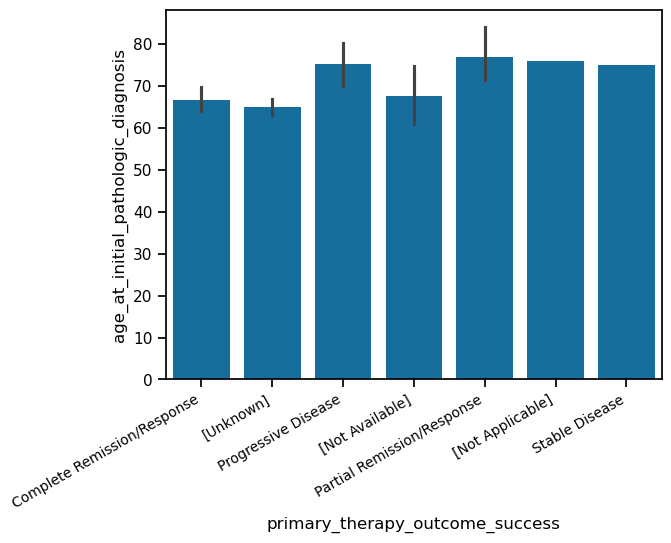

In [8]:
ax = sns.barplot(
    data=df_clinical,
    x="primary_therapy_outcome_success",
    y="age_at_initial_pathologic_diagnosis",
)

xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment="right", fontsize=10
);

In [9]:
df_clinical.query("pct_tumor_invasion != '[Not Available]'").head()

,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,clinical_stage,primary_therapy_outcome_success,new_tumor_event_after_initial_treatment,days_to_new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,vital_status,DiseaseStatus,InferredTumorStatus,Prog/Recurrence,PFS,OS,days_to_death,days_to_last_followup,form_completion_date,height,weight,race,ethnicity,prior_malignancy,radiation_therapy,postoperative_rx_tx,histological_type,year_of_initial_pathologic_diagnosis,surgical_approach,peritoneal_wash,pct_tumor_invasion,total_pelv_lnr,pln_pos_light_micro,pln_pos_ihc,total_pelv_lnp,total_aor_lnr,aln_pos_light_micro,aln_pos_ihc,total_aor-lnp,patient_id,residual_tumor,system_version,tissue_source_site,Frozen % Sarc.,Frozen % Carc.,Frozen Poorly Diff %,Serous %,Endometroid %,Poorly DifferentiatedEpith %,Squamous %,UndifferentiatedSarc %,Leiomyosarcoma %,Heterologous cartilage %,Heterologous rhabdomyosarcoma %,Heterologous other (state) %,Histologic classification
0,TCGA-N5-A4R8,65,Stage IA,Complete Remission/Response,[Unknown],[Not Available],[Unknown],Dead,DOO,DiseaseFree,No,3115,3115,3115,[Not Available],2013-05-26,164,54,WHITE,NOT HISPANIC OR LATINO,No,YES,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2003,Minimally Invasive,negative,15,26,0,0,0,8,0,0,0,A4R8,R0,2009,N5,NaN,NaN,100.0,0,15,0,0,25,0,0,60,0,Serous-like
1,TCGA-N5-A4RA,63,Stage IIIC2,[Unknown],[Unknown],[Not Available],[Unknown],Dead,DOO?,Unknown,Missing,Missing,1591,1591,[Not Available],2013-05-26,152,72,WHITE,HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2004,open,negative,67,6,1,0,1,5,3,0,3,A4RA,RX,2009,N5,98.0,2.0,NaN,5,0,0,0,95,0,0,0,0,Serous-like
2,TCGA-N5-A4RD,69,Stage IVB,Progressive Disease,YES,75,WITH TUMOR,Dead,DOD,WithDisease,Yes,75,142,142,[Not Available],2013-05-26,159,59,WHITE,NOT HISPANIC OR LATINO,No,[Unknown],[Unknown],Uterine Carcinosarcoma/ MMMT: Heterologous Type,2007,open,positive,82,1,0,0,0,0,0,0,0,A4RD,R2,2009,N5,95.0,5.0,NaN,30,0,0,0,70,0,0,0,0,Serous-like
3,TCGA-N5-A4RF,68,Stage IA,Complete Remission/Response,NO,[Not Available],TUMOR FREE,Alive,NED,DiseaseFree,No,1439,1439,[Not Applicable],1439,2013-05-26,146,49,WHITE,[Not Evaluated],No,YES,YES,Uterine Carcinosarcoma/ MMMT: Homologous Type,2008,open,negative,28,32,0,0,0,9,0,0,0,A4RF,R0,2009,N5,98.0,2.0,NaN,0,40,0,0,60,0,0,0,0,Endometrioid-like
4,TCGA-N5-A4RJ,61,Stage IVB,Complete Remission/Response,YES,287,WITH TUMOR,Dead,DOD,WithDisease,Yes,287,550,550,[Not Available],2013-05-26,158,84,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2009,open,positive,6,0,0,0,0,3,3,0,3,A4RJ,RX,2009,N5,70.0,30.0,NaN,40,0,0,0,60,0,0,0,0,Serous-like


In [10]:
# ax = sns.barplot(
#     data=df_clinical_filtered,
#     x="primary_therapy_outcome_success",
#     y="pct_tumor_invasion",
# )

In [16]:
new_col_loc = (
    next(
        idx
        for idx, col in enumerate(df_clinical.columns)
        if col == "primary_therapy_outcome_success"
    )
    + 1
)

In [11]:
# create a new column serving as a simpler binary target
targets_to_keep = [
    "Complete Remission/Response",
    "Progressive Disease",
    "Partial Remission/Response",
    "Stable Disease",
]

df_clinical_filtered = (
    df_clinical.query("primary_therapy_outcome_success in @targets_to_keep")
    .set_index("bcr_patient_barcode")
    .copy()
)

# put the new column next to the old one
new_col_loc = (
    next(
        idx
        for idx, col in enumerate(df_clinical.columns)
        if col == "primary_therapy_outcome_success"
    )
    + 1
)

# make it a simple 0/1 classification with 1 being remission/response
df_clinical_filtered.insert(
    new_col_loc,
    "primary_therapy_outcome_success_binary",
    np.where(
        df_clinical_filtered["primary_therapy_outcome_success"]
        == "Complete Remission/Response",
        1,
        0,
    ),
)

print(df_clinical_filtered.shape)
df_clinical_filtered.head()

(45, 53)


,age_at_initial_pathologic_diagnosis,clinical_stage,primary_therapy_outcome_success,new_tumor_event_after_initial_treatment,primary_therapy_outcome_success_binary,days_to_new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,vital_status,DiseaseStatus,InferredTumorStatus,Prog/Recurrence,PFS,OS,days_to_death,days_to_last_followup,form_completion_date,height,weight,race,ethnicity,prior_malignancy,radiation_therapy,postoperative_rx_tx,histological_type,year_of_initial_pathologic_diagnosis,surgical_approach,peritoneal_wash,pct_tumor_invasion,total_pelv_lnr,pln_pos_light_micro,pln_pos_ihc,total_pelv_lnp,total_aor_lnr,aln_pos_light_micro,aln_pos_ihc,total_aor-lnp,patient_id,residual_tumor,system_version,tissue_source_site,Frozen % Sarc.,Frozen % Carc.,Frozen Poorly Diff %,Serous %,Endometroid %,Poorly DifferentiatedEpith %,Squamous %,UndifferentiatedSarc %,Leiomyosarcoma %,Heterologous cartilage %,Heterologous rhabdomyosarcoma %,Heterologous other (state) %,Histologic classification
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-N5-A4R8,65,Stage IA,Complete Remission/Response,[Unknown],1,[Not Available],[Unknown],Dead,DOO,DiseaseFree,No,3115,3115,3115,[Not Available],2013-05-26,164,54,WHITE,NOT HISPANIC OR LATINO,No,YES,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2003,Minimally Invasive,negative,15,26,0,0,0,8,0,0,0,A4R8,R0,2009,N5,NaN,NaN,100.0,0,15,0,0,25,0,0,60,0,Serous-like
TCGA-N5-A4RD,69,Stage IVB,Progressive Disease,YES,0,75,WITH TUMOR,Dead,DOD,WithDisease,Yes,75,142,142,[Not Available],2013-05-26,159,59,WHITE,NOT HISPANIC OR LATINO,No,[Unknown],[Unknown],Uterine Carcinosarcoma/ MMMT: Heterologous Type,2007,open,positive,82,1,0,0,0,0,0,0,0,A4RD,R2,2009,N5,95.0,5.0,NaN,30,0,0,0,70,0,0,0,0,Serous-like
TCGA-N5-A4RF,68,Stage IA,Complete Remission/Response,NO,1,[Not Available],TUMOR FREE,Alive,NED,DiseaseFree,No,1439,1439,[Not Applicable],1439,2013-05-26,146,49,WHITE,[Not Evaluated],No,YES,YES,Uterine Carcinosarcoma/ MMMT: Homologous Type,2008,open,negative,28,32,0,0,0,9,0,0,0,A4RF,R0,2009,N5,98.0,2.0,NaN,0,40,0,0,60,0,0,0,0,Endometrioid-like
TCGA-N5-A4RJ,61,Stage IVB,Complete Remission/Response,YES,1,287,WITH TUMOR,Dead,DOD,WithDisease,Yes,287,550,550,[Not Available],2013-05-26,158,84,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2009,open,positive,6,0,0,0,0,3,3,0,3,A4RJ,RX,2009,N5,70.0,30.0,NaN,40,0,0,0,60,0,0,0,0,Serous-like
TCGA-N5-A4RM,62,Stage IVB,Progressive Disease,YES,0,144,WITH TUMOR,Dead,DOD,WithDisease,Yes,144,148,148,[Not Available],2013-05-26,152,70,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2010,open,positive,40,18,0,0,0,3,0,0,0,A4RM,RX,2009,N5,90.0,10.0,NaN,0,20,0,0,80,0,0,0,0,Serous-like


In [13]:
# consider this as a feature to add
df_clinical[["radiation_therapy", "primary_therapy_outcome_success"]].value_counts()

radiation_therapy  primary_therapy_outcome_success
YES                Complete Remission/Response        16
NO                 Complete Remission/Response        10
                   Progressive Disease                 9
                   [Not Available]                     4
YES                [Not Available]                     4
NO                 Partial Remission/Response          3
YES                Progressive Disease                 3
                   [Unknown]                           2
NO                 Stable Disease                      1
                   [Not Applicable]                    1
                   [Unknown]                           1
YES                Partial Remission/Response          1
[Unknown]          Complete Remission/Response         1
                   Progressive Disease                 1
Name: count, dtype: int64

# Additional data

In [14]:
df_mut_counts = pd.read_excel(
    Path(DATA_DIR, "Cherniack_s2_mutation_counts.xlsx"), skiprows=1
)
print(df_mut_counts.shape)
df_mut_counts.head(3)

(9149, 101)


/Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_file,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,Genome_Change,Annotation_Transcript,Transcript_Strand,Transcript_Exon,Transcript_Position,cDNA_Change,Codon_Change,Protein_Change,Other_Transcripts,Refseq_mRNA_Id,Refseq_prot_Id,SwissProt_acc_Id,SwissProt_entry_Id,Description,t_alt_count,t_ref_count,n_alt_count,n_ref_count,UniProt_AApos,UniProt_Region,UniProt_Site,UniProt_Natural_Variations,UniProt_Experimental_Info,GO_Biological_Process,GO_Cellular_Component,GO_Molecular_Function,COSMIC_overlapping_mutations,COSMIC_fusion_genes,COSMIC_tissue_types_affected,COSMIC_total_alterations_in_gene,Tumorscape_Amplification_Peaks,Tumorscape_Deletion_Peaks,TCGAscape_Amplification_Peaks,TCGAscape_Deletion_Peaks,DrugBank,ref_context,gc_content,CCLE_ONCOMAP_overlapping_mutations,CCLE_ONCOMAP_total_mutations_in_gene,CGC_Mutation_Type,CGC_Translocation_Partner,CGC_Tumor_Types_Somatic,CGC_Tumor_Types_Germline,CGC_Other_Diseases,DNARepairGenes_Role,FamilialCancerDatabase_Syndromes,MUTSIG_Published_Results,OREGANNO_ID,OREGANNO_Values,call_BCGSC,call_BCM,call_BI,call_WU,call_UCSC,validation_judgement_wes,validation_power_wes,validation_tumor_alt_count_wes,validation_tumor_ref_count_wes,validation_normal_alt_count_wes,validation_normal_ref_count_wes,validation_judgement_rna,validation_power_rna,validation_tumor_alt_count_rna,validation_tumor_ref_count_rna,validation_normal_alt_count_rna,validation_normal_ref_count_rna,num_Centers
0,AJAP1,55966,broad.mit.edu,37,1,4772258,4772258,+,Missense_Mutation,SNP,G,G,A,NaN,NaN,TCGA-N5-A4R8-01A-11D-A28R-08,TCGA-N5-A4R8-10A-01D-A28U-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Untested,Somatic,Phase_I,WXS,none,NaN,NaN,Illumina GAIIx,8a5cfe9c-405b-4e39-a4c1-a68ea61dfc6a,2204ecdd-1591-4ebf-ad83-6ec1fc3e9053,g.chr1:4772258G>A,ENST00000378191.4,+,2,709,c.328G>A,c.(328-330)Gcc>Acc,p.A110T,AJAP1_ENST00000378190.3_Missense_Mutation_p.A110T,NM_018836.3,NP_061324.1,Q9UKB5,AJAP1_HUMAN,adherens junctions associated protein 1,12,3,0,9,110.0,NaN,NaN,NaN,NaN,cell adhesion,adherens junction|apical plasma membrane|basol...,NaN,NaN,NaN,endometrium(4)|large_intestine(6)|lung(11)|ova...,24.0,all_cancers(77;0.071)|Ovarian(185;0.0721),all_cancers(23;1.77e-36)|all_epithelial(116;1....,NaN,Epithelial(90;3.89e-35)|OV - Ovarian serous cy...,NaN,CCAGGCGGCCGCCCTCGTGCC,0.736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,1,0.999968,12,3,0,9,0.0,0.000000,0.0,0.0,0.0,9.0,2
1,HSPG2,3339,broad.mit.edu,37,1,22161313,22161313,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-N5-A4R8-01A-11D-A28R-08,TCGA-N5-A4R8-10A-01D-A28U-08,NaN,NaN,C,T,C,C,NaN,Valid,Somatic,Phase_I,WXS,RNA,NaN,NaN,Illumina GAIIx,8a5cfe9c-405b-4e39-a4c1-a68ea61dfc6a,2204ecdd-1591-4ebf-ad83-6ec1fc3e9053,g.chr1:22161313C>T,ENST00000374695.3,-,77,10658,c.10579G>A,c.(10579-10581)Ggg>Agg,p.G3527R,NaN,NM_005529.5,NP_005520.4,P98160,PGBM_HUMAN,heparan sulfate proteoglycan 2,35,41,0,54,3527.0,Ig-like C2-type 21.,NaN,NaN,NaN,angiogenesis|cell adhesion|lipid metabolic pro...,basement membrane|extracellular space|plasma m...,protein C-terminus binding,NaN,NaN,breast(6)|central_nervous_system(1)|cervix(1)|...,127.0,NaN,Colorectal(325;3.46e-05)|all_lung(284;7.93e-05...,NaN,UCEC - Uterine corpus endometrioid carcinoma (...,Becaplermin(DB00102)|Palifermin(DB00039),CGCAGGTGCCCTCCAACTTTG,0.637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1.000000,38,49,0,57,1.0,1.000000,14.0,39.0,0.0,57.0,4
2,ZMYM6,9204,broad.mit.edu,37,1,35476601,35476601,+,Missense_Mutation,SNP,

# Prototype a simple pytorch model using only age as a feature

Referenced: https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

In [ ]:
# X = data.iloc[:, 0:60]
# y = data.iloc[:, 60]

# WANDB section

In [4]:
import wandb

# Run quick start

In [5]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/benlacar/.netrc


True

In [6]:
run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
)

wandb: Currently logged in as: benslack19 (benslack19-self). Use `wandb login --relogin` to force relogin


In [9]:
# train.py
import random  # for demo script

epochs = 10
lr = 0.01

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

offset = random.random() / 5
print(f"lr: {lr}")

# simulating a training run
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset
    print(f"epoch={epoch}, accuracy={acc}, loss={loss}")
    wandb.log({"accuracy": acc, "loss": loss})

# run.log_code()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


lr: 0.01
epoch=2, accuracy=0.39077614965655927, loss=0.42465757790786096
epoch=3, accuracy=0.5793069813839529, loss=0.40045406666139094
epoch=4, accuracy=0.7569201383804353, loss=0.43469313869166704
epoch=5, accuracy=0.6330842043062369, loss=0.23222180389233693
epoch=6, accuracy=0.7289425020942291, loss=0.25788110512560247
epoch=7, accuracy=0.7924265661406995, loss=0.27971094359898496
epoch=8, accuracy=0.7472078685632099, loss=0.16951062213499507
epoch=9, accuracy=0.7557763101533337, loss=0.16531536937785601


In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Dec 06 2024

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.30.0

pandas    : 2.2.3
seaborn   : 0.13.2
numpy     : 2.0.2
torch     : 2.5.1.post5
matplotlib: 3.9.2

Watermark: 2.5.0

